In [1]:
from utils import *
from pytorch_grad_cam import GradCAM

In [2]:
# sample: ./datasets/imagenette2/train
DATASETS_ROOT = '../datasets'
DATASET_NAME = 'imagenette2'

DATASET_SPLIT = 'train'

# sample: ./explanations/imagenette2/gradcam/resnet50/train
EXPLANATIONS_ROOT = '../explanations'
EXPLANATION_METHOD = 'gradcam'

NUMBER_OF_IMAGES = 128
BATCH_SIZE_IMAGES = 8
BATCH_SIZE_EXPLANATIONS = 64

path_original_images = os.path.join(DATASETS_ROOT, DATASET_NAME, DATASET_SPLIT)
imagenette_dataloader = dataset_load_imagenette(path_original_images, batch_size=BATCH_SIZE_IMAGES, shuffle=True)

---

In [3]:
from torchvision.models import resnet50, ResNet50_Weights

model_name = 'resnet50'
model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)
target_layer = [model.layer4[-1]] # resulting size is 7 x 7

path_original_images = os.path.join(DATASETS_ROOT, DATASET_NAME, DATASET_SPLIT)
imagenette_dataloader = dataset_load_imagenette(path_original_images, batch_size=BATCH_SIZE_IMAGES, shuffle=True)
path_output_explanations_resnet50 = os.path.join(EXPLANATIONS_ROOT, DATASET_NAME, EXPLANATION_METHOD, model_name, DATASET_SPLIT)
gradcam_explanation_method = GradCAM(model=model, target_layers=target_layer)

compute_gradcam_explanations_for_model_and_dataset(model, gradcam_explanation_method, imagenette_dataloader, path_output_explanations_resnet50, number_of_images=NUMBER_OF_IMAGES)

 94%|█████████▍| 15/16 [00:34<00:02,  2.27s/it]


In [4]:
from torchvision.models import resnet18, ResNet18_Weights

model_name = 'resnet18'
model = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
target_layer = [model.layer4[-1]] # resulting size is 7 x 7

path_original_images = os.path.join(DATASETS_ROOT, DATASET_NAME, DATASET_SPLIT)
imagenette_dataloader = dataset_load_imagenette(path_original_images, batch_size=BATCH_SIZE_IMAGES, shuffle=True)
path_output_explanations_resnet18 = os.path.join(EXPLANATIONS_ROOT, DATASET_NAME, EXPLANATION_METHOD, model_name, DATASET_SPLIT)
gradcam_explanation_method = GradCAM(model=model, target_layers=target_layer)

compute_gradcam_explanations_for_model_and_dataset(model, gradcam_explanation_method, imagenette_dataloader, path_output_explanations_resnet18, number_of_images=NUMBER_OF_IMAGES)

 94%|█████████▍| 15/16 [00:13<00:00,  1.09it/s]


In [5]:
from torchvision.models import swin_t, Swin_T_Weights

model_name = 'swin_t'
model = swin_t(weights=Swin_T_Weights.IMAGENET1K_V1)
target_layer = [model.features[-1][-1]] # last Swin Transformer Block

def reshape_transform(tensor): # Swin-T has tensor size BATCH x 7 x 7 x 768 at this layer
    result = tensor.transpose(2, 3).transpose(1, 2)
    return result

path_original_images = os.path.join(DATASETS_ROOT, DATASET_NAME, DATASET_SPLIT)
imagenette_dataloader = dataset_load_imagenette(path_original_images, batch_size=BATCH_SIZE_IMAGES, shuffle=True)
path_output_explanations_swin_t = os.path.join(EXPLANATIONS_ROOT, DATASET_NAME, EXPLANATION_METHOD, model_name, DATASET_SPLIT)
gradcam_explanation_method = GradCAM(model=model, target_layers=target_layer, reshape_transform=reshape_transform)

compute_gradcam_explanations_for_model_and_dataset(model, gradcam_explanation_method, imagenette_dataloader, path_output_explanations_swin_t, number_of_images=NUMBER_OF_IMAGES)

 94%|█████████▍| 15/16 [00:43<00:02,  2.91s/it]


In [6]:
from torchvision.models import vit_b_32, ViT_B_32_Weights

model_name = 'vit_b_32'
model = vit_b_32(weights=ViT_B_32_Weights.IMAGENET1K_V1)
target_layer = [model.encoder.layers[-1]] # last ViT Encoder Block

def reshape_transform(tensor, height=7, width=7): # ViT-B/32 has tensor size BATCH x 50 x 768 at this layer
    result = tensor[:, 1:, :] # remove class token
    result = result.reshape(tensor.size(0), height, width, tensor.size(2))
    result = result.transpose(2, 3).transpose(1, 2)
    return result

path_original_images = os.path.join(DATASETS_ROOT, DATASET_NAME, DATASET_SPLIT)
imagenette_dataloader = dataset_load_imagenette(path_original_images, batch_size=BATCH_SIZE_IMAGES, shuffle=True)
path_output_explanations_vit_b_32 = os.path.join(EXPLANATIONS_ROOT, DATASET_NAME, EXPLANATION_METHOD, model_name, DATASET_SPLIT)
gradcam_explanation_method = GradCAM(model=model, target_layers=target_layer, reshape_transform=reshape_transform)

compute_gradcam_explanations_for_model_and_dataset(model, gradcam_explanation_method, imagenette_dataloader, path_output_explanations_vit_b_32, number_of_images=NUMBER_OF_IMAGES)

 94%|█████████▍| 15/16 [00:43<00:02,  2.89s/it]


---

In [7]:
import pandas as pd

def compute_similarities_matrix(dataloaders_list_of_tuples, similarity_metric):
    similarities_list = []
    for dataloader_1, model_name_1 in dataloaders_list_of_tuples:
        for dataloader_2, model_name_2 in dataloaders_list_of_tuples:
            similarity = compute_models_similarity(dataloader_1, dataloader_2, similarity_metric)
            similarities_list.append((model_name_1, model_name_2, similarity))
    df = pd.DataFrame(similarities_list, columns=['Model 1', 'Model 2', 'Similarity'])
    df_matrix = df.pivot(index='Model 1', columns='Model 2', values='Similarity')
    return df_matrix

import seaborn as sns
import matplotlib.pyplot as plt

def plot_similarity_matrix(similarity_matrix, title='Similarity Matrix'):
    sns.heatmap(similarity_matrix, annot=True, cmap='Blues', vmin=0, vmax=1)
    plt.title(title)
    plt.show()

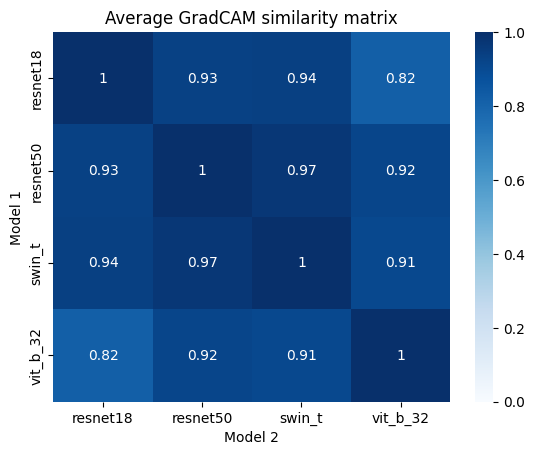

In [8]:
imagenette_gradcam_resnet50_dataloader = dataset_load_explanations(path_output_explanations_resnet50, batch_size=BATCH_SIZE_EXPLANATIONS)
imagenette_gradcam_resnet18_dataloader = dataset_load_explanations(path_output_explanations_resnet18, batch_size=BATCH_SIZE_EXPLANATIONS)
imagenette_gradcam_swint_dataloader = dataset_load_explanations(path_output_explanations_swin_t, batch_size=BATCH_SIZE_EXPLANATIONS)
imagenette_gradcam_vit_b_32_dataloader = dataset_load_explanations(path_output_explanations_vit_b_32, batch_size=BATCH_SIZE_EXPLANATIONS)

dataloaders = [
    (imagenette_gradcam_resnet50_dataloader, 'resnet50'),
    (imagenette_gradcam_resnet18_dataloader, 'resnet18'),
    (imagenette_gradcam_swint_dataloader, 'swin_t'),
    (imagenette_gradcam_vit_b_32_dataloader, 'vit_b_32')
]

similarity_matrix = compute_similarities_matrix(dataloaders, similarity_metric=similarity_metric_rbf)
plot_similarity_matrix(similarity_matrix, title='Average GradCAM similarity matrix')

---

../explanations\imagenette2\gradcam\resnet18\train\n01440764\n01440764_1514.npy
../datasets\imagenette2\train\n01440764\ILSVRC2012_val_00009379.JPEG


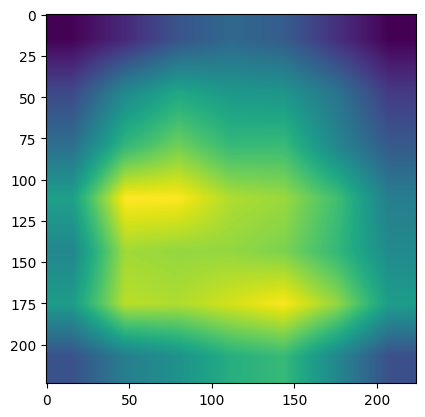

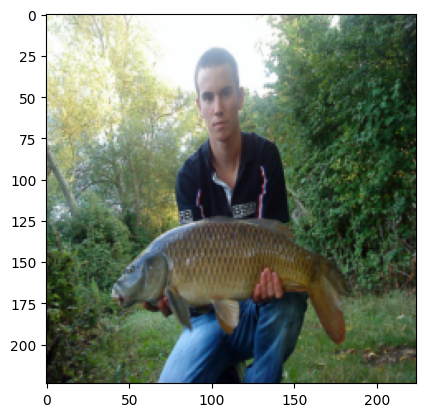

In [11]:
from matplotlib import pyplot as plt

ID = 6

imagenette_gradcam_resnet18_dataloader = dataset_load_explanations(path_output_explanations_resnet18, batch_size=BATCH_SIZE_EXPLANATIONS)
b = next(iter(imagenette_gradcam_resnet18_dataloader))

imagenette_dataloader = dataset_load_imagenette(path_original_images, batch_size=BATCH_SIZE_IMAGES, shuffle=False)
img_batch = next(iter(imagenette_dataloader))

print(b[2][ID])
print(img_batch[2][ID])

plt.imshow(b[0][ID].squeeze().numpy())
plt.show()


plt.imshow(img_batch[0][ID].permute(1, 2, 0).numpy() * 0.219 + 0.461)